###  Using the class spectral analysis

Tutorial on how to use the spectral analysis class to compute power spectrum, spectogram, and the pairwise coherence.

In [1]:
%matplotlib inline

import numpy               as np
import matplotlib.pyplot   as plt
from GDa.spectral_analysis import spectral, spectral_analysis
from GDa.session           import session

The class __spectral_analysis__ inherits from a more general class named __spectral__. Let's start by using the __spectral__ class:

In [2]:
spec = spectral()

To use the object __spec__ first we read a sample LFP signal:

In [3]:
data = np.load('raw_lfp/lucy_session01_150304.npy',allow_pickle=True).item()['data']
N    = data.shape[2]   # Number of time points 
fs   = 1000            # Sampling frequency  [Hz]

Next, we will select a random LFP signal in data:

In [4]:
lfp   = data[np.random.randint(0, data.shape[0]),np.random.randint(0, data.shape[1]),:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
time = np.linspace(-0.65, 3.00, lfp.shape[-1]) 

Text(0, 0.5, 'mV')

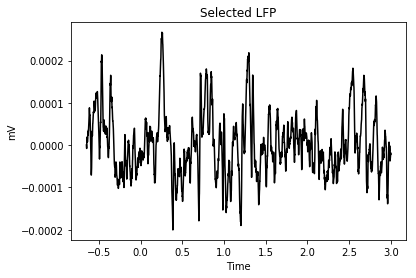

In [5]:
# Plotting the signal
plt.plot(time, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the signal with the function __filter__ in __spectral__, let's filter it on the alpha band (8-12 Hz):

In [6]:
lfp_filterd = spec.filter(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

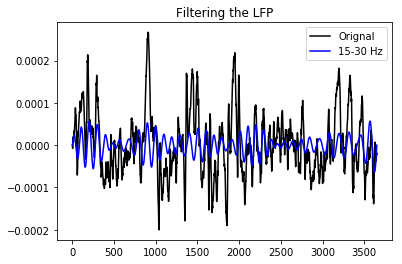

In [7]:
plt.plot(lfp, 'k')
plt.plot(lfp_filterd, 'b')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '15-30 Hz'])

We can compute the spectogram of the signal using the function __spectogram__, it is possible to use morlet or multitaper transforms.



In [8]:
fmax = 10
W_morlet     = spec.spectogram(signal = lfp[np.newaxis, np.newaxis, :], fs = fs, 
                               freqs = np.arange(6,60,.1),
                               method = 'morlet', n_jobs = -1)
W_multitaper = spec.spectogram(signal = lfp[np.newaxis, np.newaxis, :], fs = fs, 
                               freqs = np.arange(6,60,.1), 
                               method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.3s finished


Next, we can visualize the result:

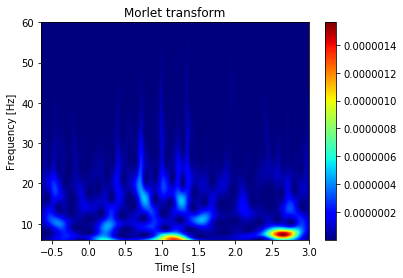

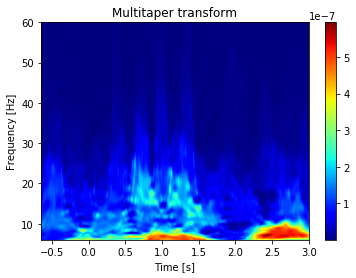

In [9]:
plt.figure()
plt.title('Morlet transform')
plt.imshow(np.squeeze(W_morlet), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()
plt.figure()
plt.title('Multitaper transform')
plt.imshow(np.squeeze(W_multitaper), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

We can measure also the instantaneous power with the function __instantaneous_power__, let's see, for instance how the power in alpha band change through time:

In [10]:
P = spec.instantaneous_power(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib64/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Power')

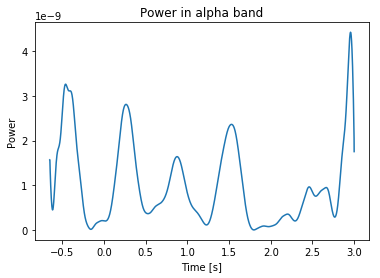

In [11]:
plt.title('Power in alpha band')
plt.plot(time, P)
plt.xlabel('Time [s]')
plt.ylabel('Power')

For all functions above we can use only one signal as input or for a matrix with dimensions [N_trials, N_channels, time].

The __spectral_analysis__ class inherits the functions from __spectral__ however it is more focused on appling then efficiently to the LFP data. We can instatiate the __spectral_analysis__ class by either passing an session object to it, or by reading the data file saved by the session object (see notebook 1).

In [15]:
# 1. INSTATIATING SPECTRAL_ANALYSIS USING A SESSION OBJECT

ses = session(raw_path = 'GrayLab/', monkey = 'lucy', stype = 'samplecor', date = '150128', 
              session = 1, evt_dt = [-0.65,3.00])

ses.read_session_info()
ses.read_lfp_data()

spec = spectral_analysis(session = ses, path = None, step = 25, dt = 250, 
                         fc = np.arange(6, 62, 2), df = 4, save_filtered = False, 
                         save_morlet = False, save_coh = True)

In [19]:
# 2. INSTATIATING SPECTRAL_ANALYSIS USING THE DATA FILE FROM SESSION

spec = spectral_analysis(session = None, path = 'raw_lfp/lucy_session01_150304.npy', step = 25, dt = 250, 
                         fc = np.arange(6, 62, 2), df = 4, save_filtered = False, 
                         save_morlet = False, save_coh = True)

In [18]:
spec